In [2]:
import keras
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, SeparableConv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, SpatialDropout2D, Flatten
from keras.models import Model
from keras import backend as K
from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline

D:\Programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Создание сверточного автокодировщика для данных cifar10

In [20]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [21]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [22]:
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
x_train.shape

(50000, 32, 32, 3)

Выделение набора для валидации.

In [23]:
x_valid = x_train[-10000:]
x_train = x_train[:-10000]
y_valid = y_train[-10000:]
y_train = y_train[:-10000]

Проверка корректности загрузки датасета.

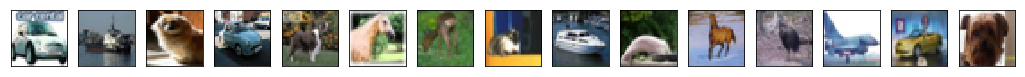

In [10]:
n = 15
plt.figure(figsize=(18,8))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [34]:
keras.backend.clear_session()

Создание модели без регуляризации. Такая последовательность слоев с количеством нейронов показала лучший результат среди испытанных. Изначально сделал попытку натренировать сверточный классификатор и использовать его часть без выходного слоя как encoder (с замороженными весами). Оказалось, это привело к несколько худшему результату. Поэтому стал обучать обе части автокодировщика (encoder и decoder) одновременно.

In [25]:
# 32-64-128-freeze-128-64-32

inp = Input(shape=(32,32,3))
x = Conv2D(64, (3, 3), padding='same')(inp)
#x = BatchNormalization()(x)
x = ReLU()(x)
#x = SpatialDropout2D(0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
#x = BatchNormalization()(x)
x = ReLU()(x)
#x = SpatialDropout2D(0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
#x = BatchNormalization(center=False, scale=False)(x)
x = ReLU()(x)
#x = SpatialDropout2D(0.2)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(inp, encoded)
#encoder.load_weights("enc_weights")
encoder.trainable = True

encoder_inp = Input(shape=(32,32,3))
encoder_out = encoder(encoder_inp)

#fla = Flatten()(encoder_out)
#dns = Dense(10, activation="softmax")(fla)
#clf = Model(encoder_inp, dns)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(encoder_out)
#x = BatchNormalization()(x)
x = ReLU()(x)
#x = SpatialDropout2D(0.2)(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
#x = BatchNormalization()(x)
x = ReLU()(x)
#x = SpatialDropout2D(0.2)(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
#x = BatchNormalization()(x)
x = ReLU()(x)
#x = SpatialDropout2D(0.2)(x)
#x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(encoder_inp, decoded)

In [26]:
#clf = Model(inp, dns)

#clf_l = Model(encoded_inp, dns)
#clf = Model(inp, clf_l(encoder))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 4, 4, 256)         370816    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
__________

Поэкспериментировал с lr(1е-1 - 1e-4). 

In [27]:
opt = keras.optimizers.Adam(lr=1e-3)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

In [28]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=30, 
                                              verbose=0, 
                                              mode='auto', 
                                              restore_best_weights=True)
history = autoencoder.fit(x_train, x_train,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_valid, x_valid),
                  callbacks=[early_stopper]
                  )

Train on 40000 samples, validate on 10000 samples
Epoch 1/300
40000/40000 [==============================] - 32s 808us/step - loss: 0.5903 - val_loss: 0.5703
Epoch 2/300
40000/40000 [==============================] - 32s 792us/step - loss: 0.5672 - val_loss: 0.5655
Epoch 3/300
40000/40000 [==============================] - 31s 784us/step - loss: 0.5628 - val_loss: 0.5617
Epoch 4/300
40000/40000 [==============================] - 31s 786us/step - loss: 0.5605 - val_loss: 0.5618
Epoch 5/300
40000/40000 [==============================] - 31s 784us/step - loss: 0.5592 - val_loss: 0.5606
Epoch 6/300
40000/40000 [==============================] - 31s 786us/step - loss: 0.5582 - val_loss: 0.5589
Epoch 7/300
40000/40000 [==============================] - 32s 791us/step - loss: 0.5574 - val_loss: 0.5581
Epoch 8/300
40000/40000 [==============================] - 32s 792us/step - loss: 0.5570 - val_loss: 0.5576
Epoch 9/300
40000/40000 [==============================] - 32s 791us/step - loss: 0.55

Наблюдается аномалия в ошибке на валидации, но, в целом, она снижается довольно плавно.

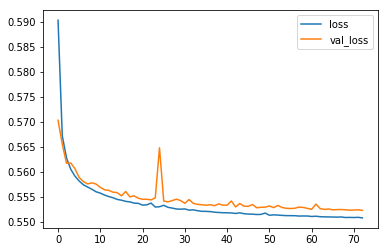

In [29]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [31]:
decoded_imgs = autoencoder.predict(x_test)

In [32]:
decoded_imgs.shape

(10000, 32, 32, 3)

Вывод результата работы автокодировщика на тестовом сете. Можно понять, что изображено на картинке, хотя и несколько размыто.

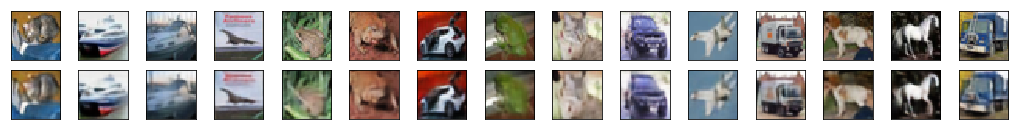

In [33]:
n = 15
plt.figure(figsize=(18,2))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i])    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Создание автокодировщика с нормализацией и dropout.

In [35]:
inp = Input(shape=(32,32,3))
x = Conv2D(64, (3, 3), padding='same')(inp)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization(center=False, scale=False)(x)
x = ReLU()(x)
x = SpatialDropout2D(0.2)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoder = Model(inp, encoded)
#encoder.load_weights("enc_weights")
encoder.trainable = True

encoder_inp = Input(shape=(32,32,3))
encoder_out = encoder(encoder_inp)

#fla = Flatten()(encoder_out)
#dns = Dense(10, activation="softmax")(fla)
#clf = Model(encoder_inp, dns)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(encoder_out)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(0.2)(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(0.2)(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = SpatialDropout2D(0.2)(x)
#x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
#decoded = keras.layers.Activation(activation="sigmoid")(x)

autoencoder = Model(encoder_inp, decoded)

In [36]:
opt = keras.optimizers.Adam(lr=1e-3)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

In [37]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=30, 
                                              verbose=0, 
                                              mode='auto', 
                                              restore_best_weights=True)
history = autoencoder.fit(x_train, x_train,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_valid, x_valid),
                  callbacks=[early_stopper]
                  )

Train on 40000 samples, validate on 10000 samples
Epoch 1/300
40000/40000 [==============================] - 44s 1ms/step - loss: 0.5918 - val_loss: 0.5753
Epoch 2/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5746 - val_loss: 0.5666
Epoch 3/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5717 - val_loss: 0.5642
Epoch 4/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5699 - val_loss: 0.5639
Epoch 5/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5690 - val_loss: 0.5629
Epoch 6/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5677 - val_loss: 0.5618
Epoch 7/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5670 - val_loss: 0.5612
Epoch 8/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5662 - val_loss: 0.5609
Epoch 9/300
40000/40000 [==============================] - 42s 1ms/step - loss: 0.5657 - val_loss: 0.5

Здесь более плавный график ошибки на тренировке, но на валидации сильнее разброс (если исключить аномалию с прошлого графика). И, хотя она сразу ушла ниже ошибки на трэйне, она выше, чем в случае без регуляризации.

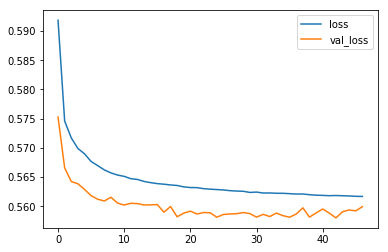

In [40]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

Результат теста. Здесь изображения более размытые, на некоторых невозможно разобрать рисунок.

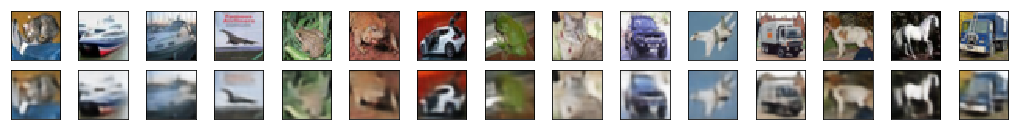

In [39]:
decoded_imgs = autoencoder.predict(x_test)

n = 15
plt.figure(figsize=(18,2))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i])    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()